# Acme Gourmet Meals Sales

## Overview

This notebook demonstrates SQL querying and data visualization skills through analysis of Acme Gourmet Meals (AGM) sales data. The analysis covers:

**Sales Analysis:**
- Total sales metrics (overall, by store, by month, by day of week)
- Revenue patterns and trends

**Customer Analysis:**
- Inactive customer identification
- Geographic customer distribution

**Product/Meal Analysis:**
- Total meals sold
- Most popular meals (overall, by location, by month)
- Temporal meal purchasing patterns

**Holiday Impact Analysis:**
- Sales during closure periods
- Holiday effects on revenue

**Data Visualizations:**
- Bar charts, line plots, heatmaps, and pie charts
- Visual insights into sales patterns and trends

---

**Note:** This analysis was performed using a PostgreSQL database hosted on a UC Berkeley MIDS AWS virtual machine environment. The database and queries are not publicly reproducible.


### Supporting Code

In [21]:
import math
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Database connection to UC Berkeley AWS PostgreSQL instance
connection = psycopg2.connect(
    user = "postgres",
    password = "****", # hidden
    host = "postgres",
    port = "5432",
    database = "postgres"
)

Below I define a function to run a select query and return the results in a pandas dataframe, which converts all numeric values from postgres into a float or integer. 

In [23]:
def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [24]:
rollback_before_flag = True
rollback_after_flag = True

## Sales Queries

### Sales by Store Location

This query shows total sales amount, number of sales, and average sale amount for each store location.

In [25]:
query = """

select  st.city as store_location,
        sum(total_amount) as total_sales_dollars,
        sum(total_amount)/1000000 as total_sales_million_dollars,
        count(*) as total_number_of_sales,
        round(sum(total_amount)/count(*),2) as average_dollar_amount_per_sale
        
from sales as sa
    join stores as st
        on sa.store_id = st.store_id
group by st.city
order by st.city

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,store_location,total_sales_dollars,total_sales_million_dollars,total_number_of_sales,average_dollar_amount_per_sale
0,Berkeley,25041060,25.041060,390375,64.15
1,Dallas,19408260,19.408260,302120,64.24
2,Miami,17692404,17.692404,275074,64.32
3,Nashville,14573172,14.573172,227721,64.00
4,Seattle,22024512,22.024512,342327,64.34


### Sales by Month

This query breaks down sales by month, showing the seasonal patterns in the business.

In [26]:
query = """

select  extract(month from sale_date) as month_number,
        to_char(sale_date, 'Month') as month,
        sum(total_amount) as total_sales_dollars,
        round(sum(total_amount)/1000000,1) as total_sales_million_dollars,
        count(*) as total_number_of_sales,
        round(sum(total_amount)/count(*),2) as average_dollar_amount_per_sale
        
from sales
group by extract(month from sale_date),
         to_char(sale_date, 'Month')
order by month_number

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month_number,month,total_sales_dollars,total_sales_million_dollars,total_number_of_sales,average_dollar_amount_per_sale
0,1,January,7803828,7.8,121955,63.99
1,2,February,7574280,7.6,117984,64.20
2,3,March,8779620,8.8,136653,64.25
3,4,April,8251284,8.3,128155,64.39
4,5,May,7977840,8.0,124380,64.14
5,6,June,8124108,8.1,126248,64.35
6,7,July,7993044,8.0,124290,64.31
7,8,August,9029808,9.0,140467,64.28
8,9,September,7578960,7.6,117974,64.24
9,10,October,8895108,8.9,138731,64.12


### Sales by Day of Week

This query analyzes which days of the week generate the most sales.

In [27]:
query = """

select  extract(dow from sale_date) as dow,
        to_char(sale_date, 'Day') as day_of_week,
        sum(total_amount) as total_sales_dollars,
        round(sum(total_amount)/1000000,1) as total_sales_million_dollars,
        count(*) as total_number_of_sales,
        round(sum(total_amount)/count(*),2) as average_dollar_amount_per_sale
        
from sales
group by extract(dow from sale_date),
         to_char(sale_date, 'Day')
order by dow

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,dow,day_of_week,total_sales_dollars,total_sales_million_dollars,total_number_of_sales,average_dollar_amount_per_sale
0,0,Sunday,18589068,18.6,289869,64.13
1,1,Monday,13167720,13.2,204909,64.26
2,2,Tuesday,6895332,6.9,107488,64.15
3,3,Wednesday,13952556,14.0,217288,64.21
4,4,Thursday,13834644,13.8,214969,64.36
5,5,Friday,12878628,12.9,201039,64.06
6,6,Saturday,19421460,19.4,302055,64.30


## Customer Analysis

### Customers Who Signed Up But Never Made a Purchase

This query identifies inactive customers who registered but haven't completed a transaction yet.

In [28]:
query = """

select  count(*) as customers_with_no_purchases
from customers as c
where not exists (
    select 1
    from sales as s
    where s.customer_id = c.customer_id
)

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customers_with_no_purchases
0,35


### Customer Distribution by Zip Code

This query shows the percentage of customers in each zip code, helping identify key market areas.

In [29]:
query = """

select  zip,
        count(*) as customer_count,
        round(100.0 * count(*) / sum(count(*)) over(), 2) as percentage_of_customers
from customers
group by zip
order by customer_count desc

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,zip,customer_count,percentage_of_customers
0,33134,419,1.35
1,98117,315,1.01
2,98125,296,0.95
3,94602,260,0.84
4,94530,258,0.83
...,...,...,...
545,76182,1,0.00
546,37048,1,0.00
547,75025,1,0.00
548,76012,1,0.00


## Meal/Product Analysis

### Total Meals Sold

This query calculates the total number of meals purchased across all stores.

In [30]:
query = """

select  sum(quantity) as total_meals_purchased
from line_items

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,total_meals_purchased
0,8228284


### Most Popular Meal by Store Location

This query identifies the best-selling meal at each store location.

In [31]:
query = """

with meal_counts as (
    select  st.city as store_location,
            pr.description as meal_name,
            sum(li.quantity) as total_meals_purchased,
            row_number() over (partition by st.city order by sum(li.quantity) desc) as rank
    from line_items as li
        join sales as sa on li.sale_id = sa.sale_id
        join stores as st on sa.store_id = st.store_id
        join products as pr on li.product_id = pr.product_id
    group by st.city, pr.description
)
select  store_location,
        meal_name,
        total_meals_purchased
from meal_counts
where rank = 1
order by store_location

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,store_location,meal_name,total_meals_purchased
0,Berkeley,Pistachio Salmon,1828778
1,Dallas,Pistachio Salmon,1676347
2,Miami,Pistachio Salmon,1580119
3,Nashville,Pistachio Salmon,1355245
4,Seattle,Pistachio Salmon,1771890


### Most Popular Meals by Month

This query shows which meals are most popular during each month of the year.

In [32]:
query = """

with meal_counts as (
    select  extract(month from sa.sale_date) as month_number,
            to_char(sa.sale_date, 'Month') as month,
            pr.description as meal_name,
            sum(li.quantity) as total_meals_purchased,
            row_number() over (partition by extract(month from sa.sale_date) 
                             order by sum(li.quantity) desc) as rank
    from line_items as li
        join sales as sa on li.sale_id = sa.sale_id
        join products as pr on li.product_id = pr.product_id
    group by extract(month from sa.sale_date), to_char(sa.sale_date, 'Month'), pr.description
)
select  month_number,
        month,
        meal_name,
        total_meals_purchased
from meal_counts
where rank = 1
order by month_number

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month_number,month,meal_name,total_meals_purchased
0,1,January,Pistachio Salmon,720970
1,2,February,Pistachio Salmon,700318
2,3,March,Pistachio Salmon,814043
3,4,April,Pistachio Salmon,763593
4,5,May,Pistachio Salmon,740545
5,6,June,Pistachio Salmon,751809
6,7,July,Pistachio Salmon,740793
7,8,August,Pistachio Salmon,798289
8,9,September,Pistachio Salmon,619858
9,10,October,Pistachio Salmon,639518


### Total Meals by Month

This query shows the total number of meals sold in each month.

In [33]:
query = """

select  extract(month from sa.sale_date) as month_number,
        to_char(sa.sale_date, 'Month') as month,
        sum(li.quantity) as total_meals_purchased
from line_items as li
    join sales as sa on li.sale_id = sa.sale_id
group by extract(month from sa.sale_date), to_char(sa.sale_date, 'Month')
order by month_number

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month_number,month,total_meals_purchased
0,1,January,3252637
1,2,February,3152564
2,3,March,3660355
3,4,April,3435052
4,5,May,3330027
5,6,June,3380074
6,7,July,3326135
7,8,August,3591531
8,9,September,2785597
9,10,October,2876508


### Total Meals by Day of Week and Month

This query provides a more granular view combining day of week and month.

In [34]:
query = """

select  extract(month from sa.sale_date) as month_number,
        to_char(sa.sale_date, 'Month') as month,
        extract(dow from sa.sale_date) as dow,
        to_char(sa.sale_date, 'Day') as day_of_week,
        sum(li.quantity) as total_meals_purchased
from line_items as li
    join sales as sa on li.sale_id = sa.sale_id
group by extract(month from sa.sale_date), to_char(sa.sale_date, 'Month'),
         extract(dow from sa.sale_date), to_char(sa.sale_date, 'Day')
order by month_number, dow

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,month_number,month,dow,day_of_week,total_meals_purchased
0,1,January,0,Sunday,552389
1,1,January,1,Monday,382600
2,1,January,2,Tuesday,221511
3,1,January,3,Wednesday,496959
4,1,January,4,Thursday,549259
...,...,...,...,...,...
79,12,December,2,Tuesday,150926
80,12,December,3,Wednesday,302267
81,12,December,4,Thursday,304340
82,12,December,5,Friday,181570


## Holiday Analysis

### Actual Sales for 2020 Including Closure Days

This query shows actual sales for 2020, including days when AGM was closed (showing $0 sales).

In [35]:
query = """

with date_range as (
    select generate_series(
        '2020-01-01'::date,
        '2020-12-31'::date,
        '1 day'::interval
    )::date as date
)
select  dr.date,
        to_char(dr.date, 'Day') as day_of_week,
        coalesce(sum(sa.total_amount), 0) as total_sales
from date_range as dr
    left join sales as sa on sa.sale_date = dr.date
group by dr.date
order by dr.date

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,date,day_of_week,total_sales
0,2020-01-01,Wednesday,133776
1,2020-01-02,Thursday,261120
2,2020-01-03,Friday,263076
3,2020-01-04,Saturday,400368
4,2020-01-05,Sunday,394992
...,...,...,...
361,2020-12-27,Sunday,396096
362,2020-12-28,Monday,264852
363,2020-12-29,Tuesday,130440
364,2020-12-30,Wednesday,263424


### Holidays with Significant Sales Decrease

This query identifies holidays where actual sales decreased by 10% or more compared to expected sales within one week of the holiday.

In [39]:
query = """

with holiday_sales as (
    select  h.description as holiday_name,
            h.holiday_date,
            sum(sa.total_amount) as actual_sales,
            avg(sa.total_amount) * count(*) as expected_sales
    from holidays as h
        left join sales as sa on sa.sale_date between h.holiday_date - interval '7 days'
                                                  and h.holiday_date + interval '7 days'
    group by h.description, h.holiday_date
)
select  holiday_name,
        holiday_date,
        actual_sales,
        expected_sales,
        round(100.0 * (actual_sales - expected_sales) / expected_sales, 2) as percent_difference
from holiday_sales
where (actual_sales - expected_sales) / expected_sales <= -0.10
order by percent_difference

"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,holiday_name,holiday_date,actual_sales,expected_sales,percent_difference


## Data Visualizations

Now let's create some visualizations to better understand the sales patterns.

### Sales by Store Location - Bar Chart

This visualization compares total sales across different store locations.

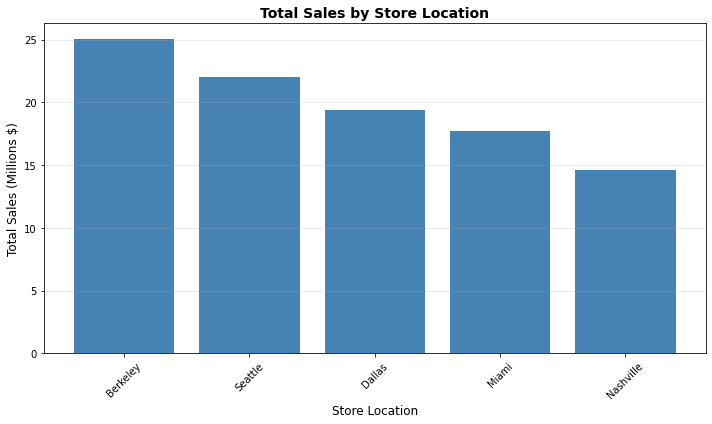

In [40]:
query = """
select  st.city as store_location,
        sum(total_amount)/1000000 as total_sales_millions
from sales as sa
    join stores as st on sa.store_id = st.store_id
group by st.city
order by total_sales_millions desc
"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

plt.figure(figsize=(10, 6))
plt.bar(df['store_location'], df['total_sales_millions'], color='steelblue')
plt.xlabel('Store Location', fontsize=12)
plt.ylabel('Total Sales (Millions $)', fontsize=12)
plt.title('Total Sales by Store Location', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Monthly Sales Trend - Line Chart

This visualization shows how sales vary throughout the year.

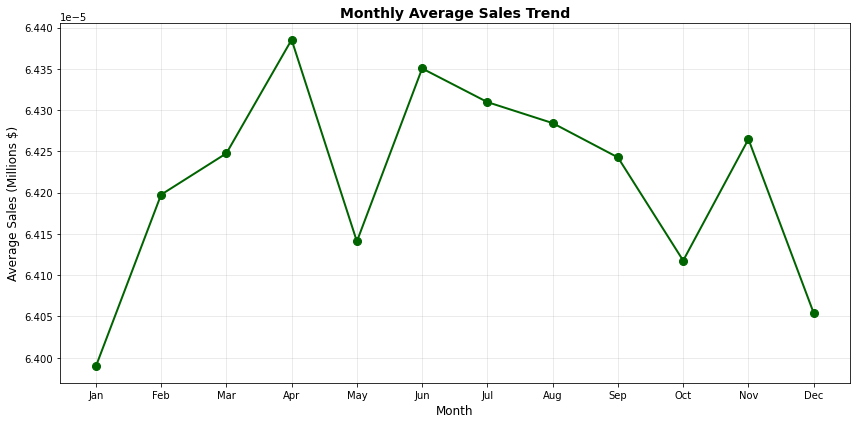

In [41]:
query = """
select  extract(month from sale_date) as month_number,
        to_char(sale_date, 'Mon') as month_abbr,
        avg(total_amount)/1000000 as total_sales_millions
from sales
group by extract(month from sale_date), to_char(sale_date, 'Mon')
order by month_number
"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

plt.figure(figsize=(12, 6))
plt.plot(df['month_abbr'], df['total_sales_millions'], marker='o', linewidth=2, markersize=8, color='darkgreen')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Sales (Millions $)', fontsize=12)
plt.title('Monthly Average Sales Trend', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Sales by Day of Week - Heatmap

This visualization shows which days of the week are busiest for each store.

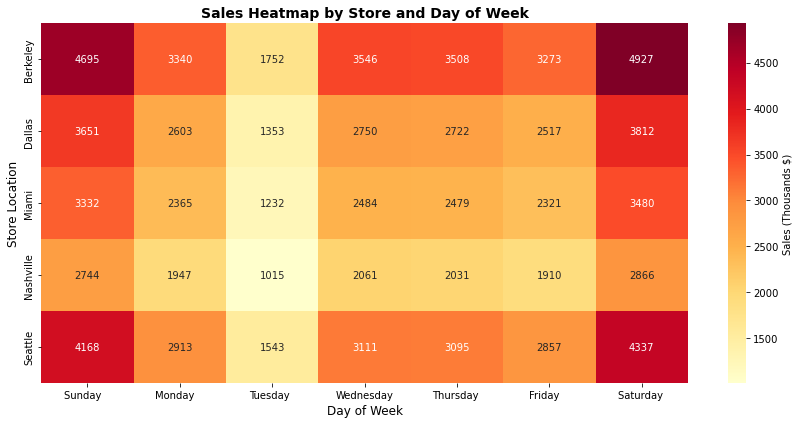

In [42]:
query = """
select  st.city as store_location,
        extract(dow from sa.sale_date) as dow,
        to_char(sa.sale_date, 'Day') as day_of_week,
        sum(sa.total_amount)/1000 as total_sales_thousands
from sales as sa
    join stores as st on sa.store_id = st.store_id
group by st.city, extract(dow from sa.sale_date), to_char(sa.sale_date, 'Day')
order by st.city, dow
"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
pivot_df = df.pivot(index='store_location', columns='day_of_week', values='total_sales_thousands')

# Reorder columns to start with Sunday
day_order = ['Sunday   ', 'Monday   ', 'Tuesday  ', 'Wednesday', 'Thursday ', 'Friday   ', 'Saturday ']
pivot_df = pivot_df[day_order]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Sales (Thousands $)'})
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Store Location', fontsize=12)
plt.title('Sales Heatmap by Store and Day of Week', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Top 10 Meals - Pie Chart

This visualization shows the most popular meals by total quantity sold.

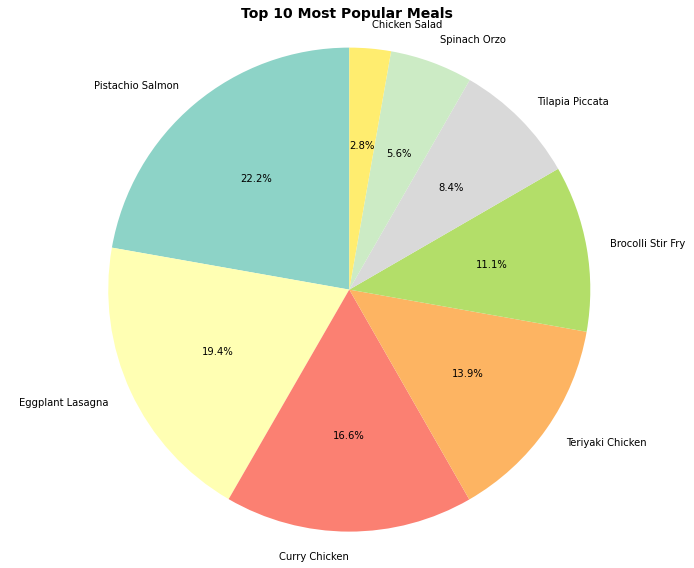

In [43]:
query = """
select  pr.description as meal_name,
        sum(li.quantity) as total_quantity
from line_items as li
    join products as pr on li.product_id = pr.product_id
group by pr.description
order by total_quantity desc
limit 10
"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

plt.figure(figsize=(10, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(df)))
plt.pie(df['total_quantity'], labels=df['meal_name'], autopct='%1.1f%%', 
        startangle=90, colors=colors)
plt.title('Top 10 Most Popular Meals', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Key Insights and Analytics

Based on the queries and visualizations above, we can draw several important insights:

1. **Store Performance**: The analysis reveals which store locations generate the most revenue and have the highest average transaction values.

2. **Seasonal Patterns**: Monthly sales data shows seasonal trends that can inform inventory management and staffing decisions.

3. **Weekly Trends**: Day-of-week analysis helps optimize delivery schedules and promotional campaigns for peak business days.

4. **Customer Engagement**: Identifying customers who signed up but never purchased presents an opportunity for targeted marketing campaigns.

5. **Product Mix**: Understanding which meals are most popular overall and by location enables better menu planning and inventory optimization.

6. **Holiday Impact**: The holiday analysis reveals which holidays significantly affect sales, helping to plan for closures or special promotions.

These insights demonstrate the value of combining SQL analytics with data visualization to drive business decisions in the food delivery industry.